<h1 style="text-align: center; font-size: 3.5rem; font-weigth: bold; margin-top: 170px;">
  Geospatial ML Challenges: A prospectivity analysis example
</h1>

<h2 style="text-align: center; margin-bottom: 120px;">
  Thomas Ostersen & Tom Carmichael
</h2>

<h3 style="text-align: center;"><strong>Repository for the tutorial:</strong> <a href="https://github.com/Solve-Geosolutions/transform_2022">github.com/Solve-Geosolutions/transform_2022</a></h3>

<div align="center" style="margin-bottom: 100px;">
    <center><img src="assets/swung.svg" style="height: 100px; margin-bottom:50px"></center>
    <center><img src="assets/datarock-black.png" style="height: 100px"></center>
</div>

## Study Area: Northeastern Tasmania

* Oldest rocks belong to thick package of folded Ordovician Mathinna Supergroup sediments
* These extensively intruded by granitoids in the Devonian
* Study area is prospective for intrusion related tin-tungsten and gold mineralisation

<img src="assets/hong_et_al_2019_tasgeomap.png" style="width: 800px" />

<center>Figure modifed from <a href=https://doi.org/10.2138/am-2019-6534>Hong et al, (2019)</a></center>

## Download Data Sets

  1. Download the zipped data set from our [Google drive location](https://drive.google.com/file/d/1ahrYZlvnrZuSdDrwEbhajFrofC3VQPek/view?usp=sharing)
  
<img src="assets/download_data.png" style="width: 400px" />
  
  2. Unzip the data directory 
  

## Roadmap

  1. Load and inspect data sets
      - mineral occurence point data sets with *geopandas*
      - gravity, magnetic and radiometric data sets with *rasterio*
  1. Combine data sets to build a labeled N<sub>pixel</sub>, N<sub>layers</sub> array for model training
      - inspect differences between proximal vs. distal to mineralisation pixels      
  1. Train a random forest classifier and apply to all pixels, visualise results
      - evaluate performance with a randomly selected testing subset
      - repeat with stratified classes      
  1. Develop a checkerboard data selection procedure, train and evaluate models
      - discuss effects of spatially separated testing data      
  1. Investigate occurence holdout models with a spatially clustered approach
 
---

In [1]:
# import key packages
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# set some plotting parameters 
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

In [2]:
# set path to data directory
data_dir = r'/mnt/c/Users/thoma/Desktop/transform_2022/data'

# set path to minoccs
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')

# make a list of rasters in the data directory
geotiffs = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x]
point_fn, geotiffs

('/mnt/c/Users/thoma/Desktop/transform_2022/data/sn_w_minoccs.gpkg',
 ['/mnt/c/Users/thoma/Desktop/transform_2022/data/tasgrav_IR.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasgrav_IR_1VD.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasmag_TMI.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasmag_TMI_1VD.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasrad_K_pct.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasrad_Th_ppm.tif',
  '/mnt/c/Users/thoma/Desktop/transform_2022/data/tasrad_U_ppm.tif'])

<AxesSubplot:>

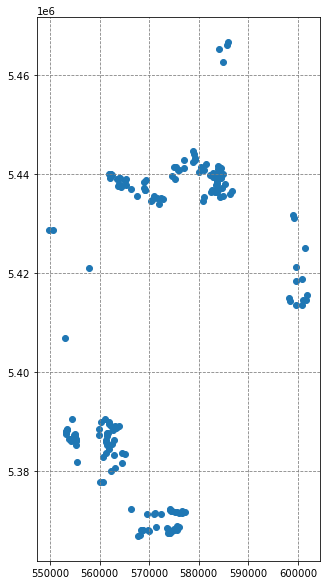

In [4]:
# import geopandas
import geopandas as gpd

# read occurences
df = gpd.read_file(point_fn)
df.plot()

In [6]:
# import rasterio
import rasterio

# read geotiffs
data, names = [], []
for fn in geotiffs:
    with rasterio.open(fn, 'r') as src:
        # read spatial information
        transform = src.transform
        region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        # read band 1 data
        d = src.read(1)
        nodata_mask = d == src.nodata
        d[nodata_mask] = np.nan
        # append data to lists
        data.append(d)
        names.append(os.path.basename(fn).replace('.tif',''))

# stack list into 3D numpy array
data = np.stack(data)
data.shape, names

((7, 2633, 1876),
 ['tasgrav_IR',
  'tasgrav_IR_1VD',
  'tasmag_TMI',
  'tasmag_TMI_1VD',
  'tasrad_K_pct',
  'tasrad_Th_ppm',
  'tasrad_U_ppm'])

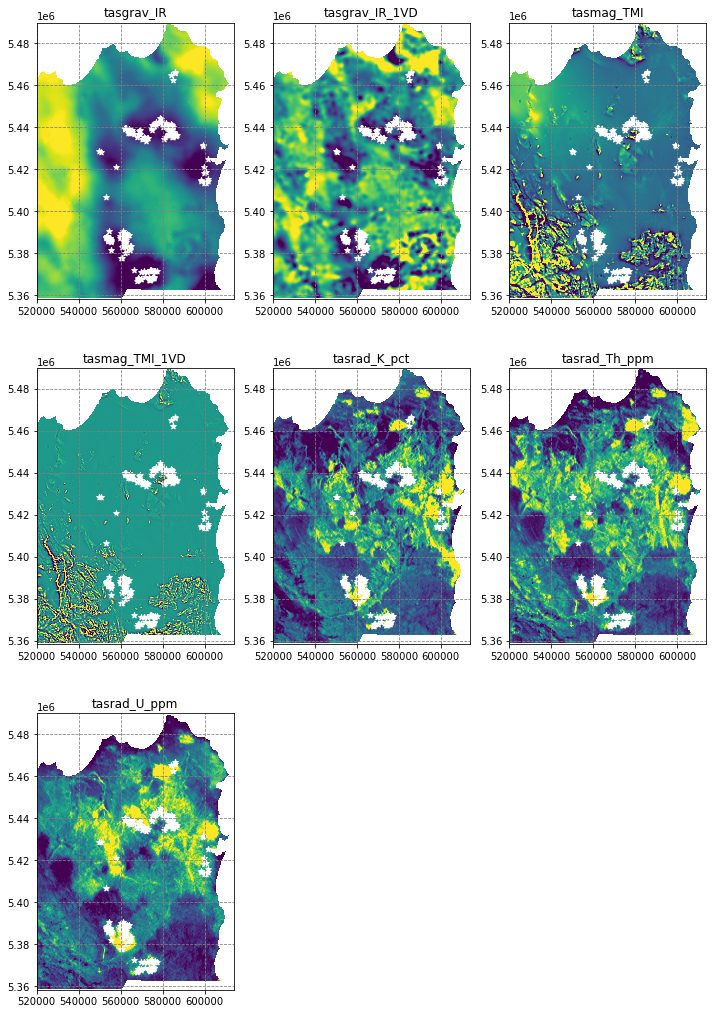

In [11]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        df.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

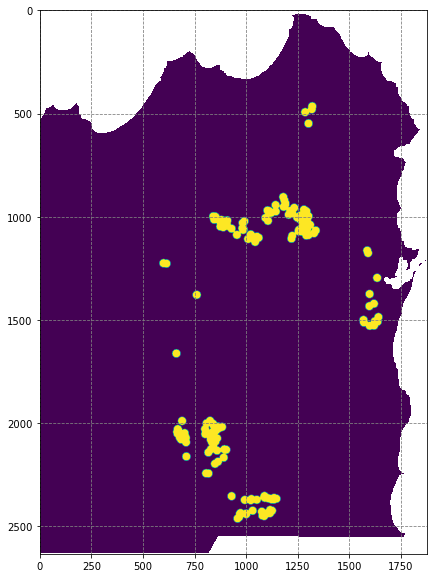

In [15]:
# import rasterize module
from rasterio.features import rasterize

# rasterize the point
geometry_generator = ((geom, 1) for geom in df.buffer(1000).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan

plt.imshow(labels)

In [22]:
# convert 3D data cube to 2D tabular array
X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = labels.flatten()

# remove nans
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]

X.shape, y.shape

((4002948, 7), (4002948,))

## Train Models

In [25]:
# import modelling modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# generate train and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=420)

# define model
model1 = RandomForestClassifier(n_jobs=-1)
model1.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

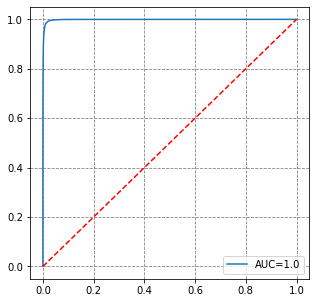

In [28]:
# import metrics
from sklearn.metrics import roc_curve, auc

# evaluate model on test data
y_proba = model1.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC={}'.format(round(roc_auc, 2)))
ax.plot([0,1], [0,1], 'r--')
ax.legend()
plt.show()

In [75]:
# define a function to get probability map
def get_proba_map(X_pix, nodata_mask, model):
    # remove nulls
    X = X_pix[np.invert(nodata_mask.flatten())]
    # get predictions
    predictions = model.predict_proba(X)[:,1]
    # create output array
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    # insert predictions
    pred_ar[np.invert(nodata_mask.flatten())] = predictions
    # reshape to spatial
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    pred_ar[nodata_mask] = np.nan
    return pred_ar
    
pred_ar1 = get_proba_map(X_pix, nodata_mask, model1)

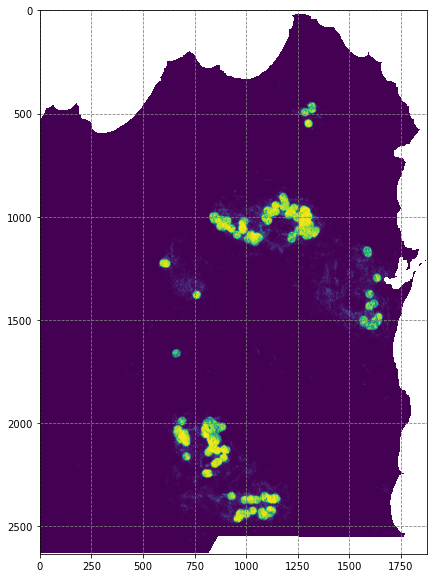

In [32]:
plt.imshow(pred_ar1)

In [35]:
# import random undersampler
from imblearn.under_sampling import RandomUnderSampler

# stratify classes with random undersampler
rus = RandomUnderSampler(random_state=32)
X_strat, y_strat = rus.fit_resample(X, y)

# generate training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_strat, y_strat, test_size=0.33, random_state=42)

# define model and fit it
model2 = RandomForestClassifier(n_jobs=-1)
model2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

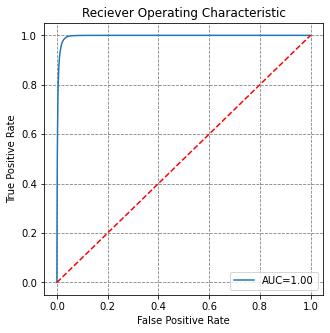

In [36]:
# evaluate the model on the test data set
y_preds = model2.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC=%0.2f' % roc_auc)
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

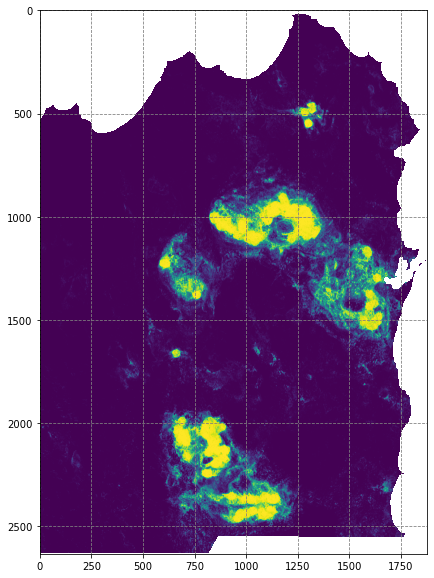

In [37]:
pred_ar2 = get_proba_map(X_pix, nodata_mask, model2)
plt.imshow(pred_ar2)

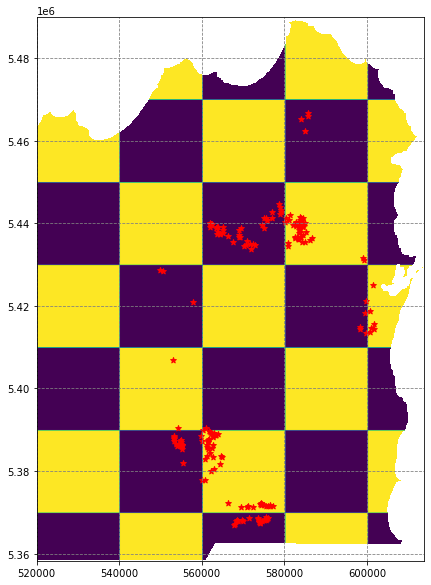

In [41]:
# define checkerboard function 
def make_checkerboard(boardsize, squaresize):
  '''
  props to stackoverflow user Blubberguy22, posted March 17, 2020 at 19:00
  https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
  '''
  return np.fromfunction(lambda i, j: (i//squaresize[0])%2 != (j//squaresize[1])%2, boardsize).astype('float32')

# make checkerboard
checker = make_checkerboard(data[0].shape, (400,400))
checker[nodata_mask] = np.nan

#plot checkerboard
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(checker, extent=region)
df.plot(ax=ax, marker='*', facecolor='r')
plt.show()

In [43]:
# data into checkers
X_check0 = X_pix[checker.flatten()==0]
y_check0 = y_pix[checker.flatten()==0]

X_check1 = X_pix[checker.flatten()==1]
y_check1 = y_pix[checker.flatten()==1]

# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# run undersampling
X_check0, y_check0 = rus.fit_resample(X_check0, y_check0)
X_check1, y_check1 = rus.fit_resample(X_check1, y_check1)

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

Checker 0: X data array shape is (1949724, 7), y labels array shape is (1949724,)
Checker 1: X data array shape is (2053224, 7), y labels array shape is (2053224,)
Checker 0: X data array shape is (114860, 7), y labels array shape is (114860,)
Checker 1: X data array shape is (106618, 7), y labels array shape is (106618,)


In [44]:
# fit some models
model3 = RandomForestClassifier(n_jobs=-1)
model4 = RandomForestClassifier(n_jobs=-1)

model3.fit(X_check0, y_check0)
model4.fit(X_check1, y_check1)

RandomForestClassifier(n_jobs=-1)

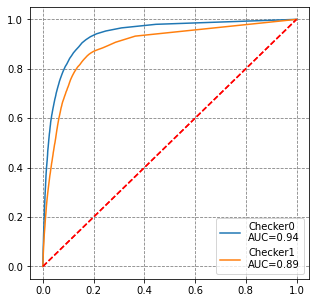

In [47]:
# get roc_curve data
roc_data = []
for model, X_check, y_check in zip([model3, model4],[X_check1, X_check0],[y_check1, y_check0]):
    y_pred = model.predict_proba(X_check)[:,1]
    fpr, tpr, _ = roc_curve(y_check, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr, tpr, roc_auc))
    
# plot all this 
fig, ax = plt.subplots(figsize=(5,5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
    ax.plot(fpr, tpr, label='Checker{}\nAUC={}'.format(i, round(roc_auc,2)))
    ax.plot([0,1], [0,1], 'r--')
    ax.legend()
plt.show()

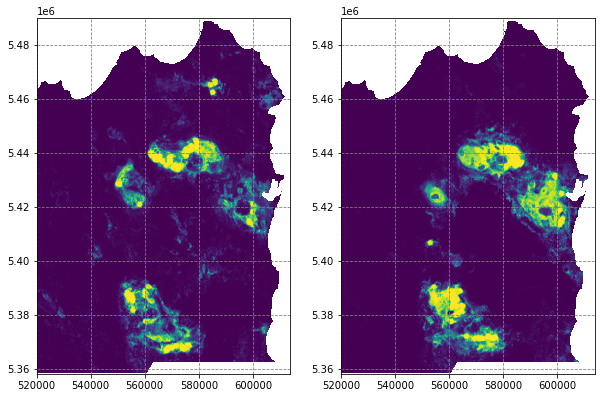

In [49]:
# generate probability maps
pred_ar3 =  get_proba_map(X_pix, nodata_mask, model3)
pred_ar4 = get_proba_map(X_pix, nodata_mask, model4)

# plot probability maps
fig, ax = plt.subplots(1,2,figsize=(10,10))
for i, ar in enumerate([pred_ar3, pred_ar4]):
    ax[i].imshow(ar, extent=region)
#     df.plot(ax=ax[i], marker='*', facecolor='w')
plt.show()

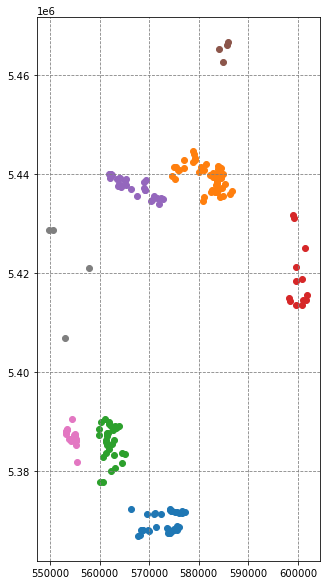

In [60]:
# import kmeans clustering 
from sklearn.cluster import KMeans

# get occurence points
xy_pnts = [[geom.x, geom.y] for geom in df.geometry]
kmeans_obj = KMeans(n_clusters=8).fit(xy_pnts)
df['labels'] = kmeans_obj.labels_ +1

# plot clustered points
fig, ax = plt.subplots(figsize=(10,10))
for c in sorted(df.labels.unique()):
    df[df.labels==c].plot(ax=ax)
#     ax.legend()
plt.show()

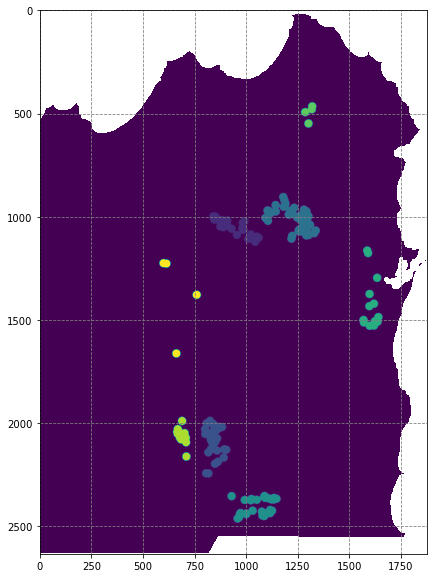

In [57]:
# generate raster label
geometry_generator = ((geom, c) for c, geom in zip(df.labels, df.buffer(1000).geometry))
clustermap = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
clustermap[nodata_mask] = np.nan

plt.imshow(clustermap)

In [66]:
# create a data selection function
def cluster_pixel_selection(clustermap, data_cube, class_1_list):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  y[np.isin(y, class_1_list)] = 1
  y[y!=1] = 0
  return X, y

# create a function to fit a model to input data
def fit_stratifiedrandomforest(X, y):
  X, y = rus.fit_resample(X, y)
  model = RandomForestClassifier(n_estimators=15, n_jobs=-1)
  return model.fit(X, y)

# define a function to determine performance on holdout occurence clusters
def holdout_roc_auc(clustermap, data_cube, holdout_cluster_list, model_cluster_list, model):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  X = X[~np.isin(y, model_cluster_list)]
  y = y[~np.isin(y, model_cluster_list)]
  y[np.isin(y, holdout_cluster_list)] = 1
  # predict onto X
  y_pred = model.predict_proba(X)
  fpr, tpr, threshold = roc_curve(y, y_pred[:,1])
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

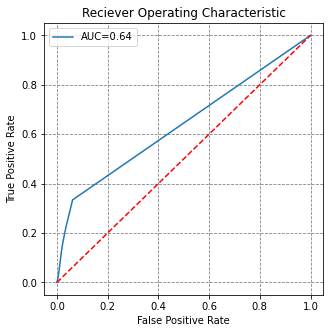

In [67]:
# train a model on cluster 1
X, y = cluster_pixel_selection(clustermap, data, [1])
model = fit_stratifiedrandomforest(X, y)
fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [2,3,4,5,6,7,8], [1], model)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC={}'.format(round(roc_auc,2)))
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()


In [69]:
# loop through clusters
models = []
fprs, tprs, roc_aucs = [], [], []
for i in sorted(df.labels.unique()):
    X, y = cluster_pixel_selection(clustermap, data, [j for j in range(1,9) if j!=i])
    model = fit_stratifiedrandomforest(X, y)
    fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [i], [j for j in range(1,9) if j!=i], model)
    models.append(model)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

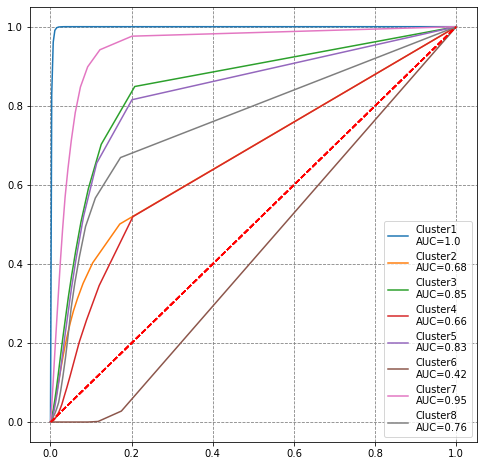

In [73]:
fig, ax = plt.subplots(figsize=(8,8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs, tprs, roc_aucs)):
    ax.plot(fpr, tpr, label='Cluster{}\nAUC={}'.format(i+1, round(roc_auc, 2)))
    ax.plot([0,1], [0,1], 'r--')
    ax.legend()
    

In [76]:
# loop through models and get probability maps
prob_maps = []
for m in models:
    prob_maps.append(get_proba_map(X_pix, nodata_mask, m))


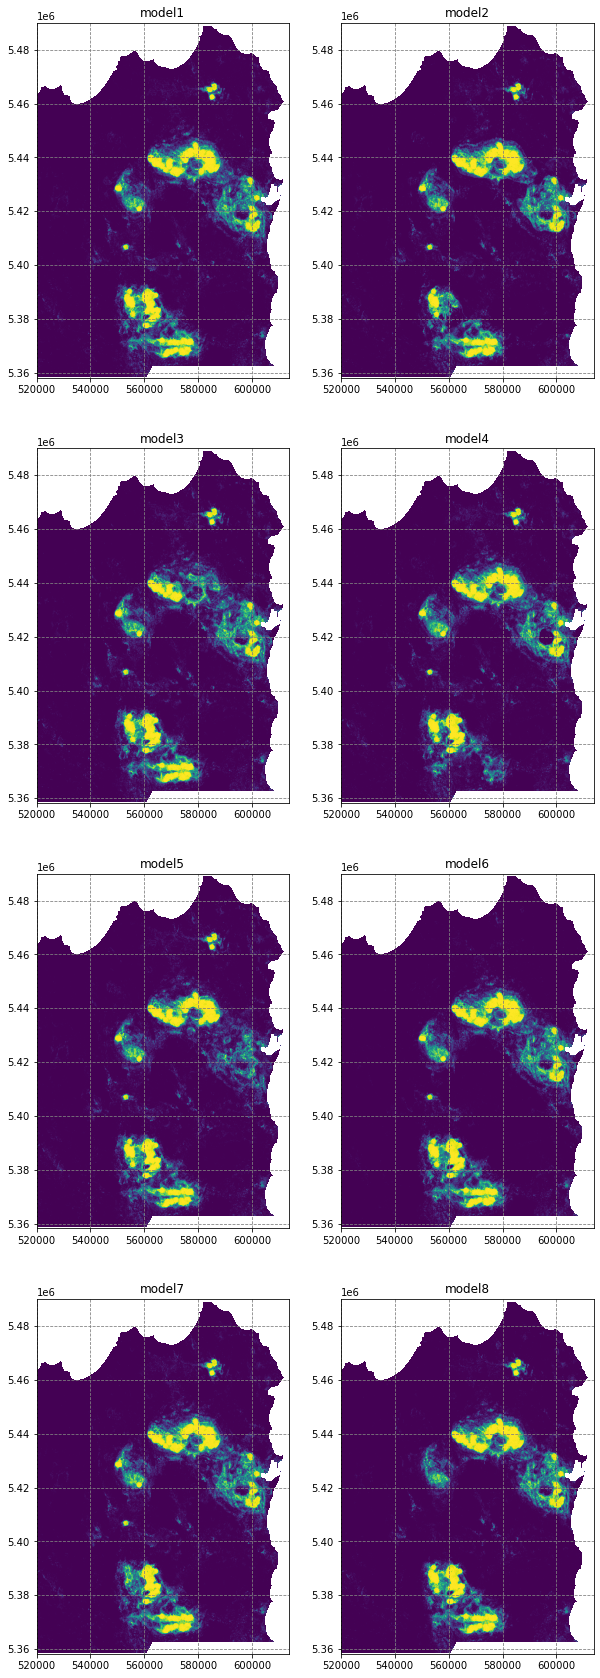

In [80]:
# plot all models
fig, axes = plt.subplots(4,2, figsize=(10,30))
for i, ax in enumerate(axes.flatten()):
    im = ax.imshow(prob_maps[i], extent=region)
    ax.set(title='model'+str(i+1))
plt.show()
